In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import itertools

plt.style.use('ggplot')
%matplotlib inline


In [17]:
# Set paths to dataset
train_dir = r"./chest_xray/chest_xray/train"
val_dir = r"./chest_xray/chest_xray/val"
test_dir = r"./chest_xray/chest_xray/test"

# Image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_generator = valid_test_datagen.flow_from_directory(val_dir,
                                                       target_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')

test_generator = valid_test_datagen.flow_from_directory(test_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

# Check classes
print("Class indices:", train_generator.class_indices)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


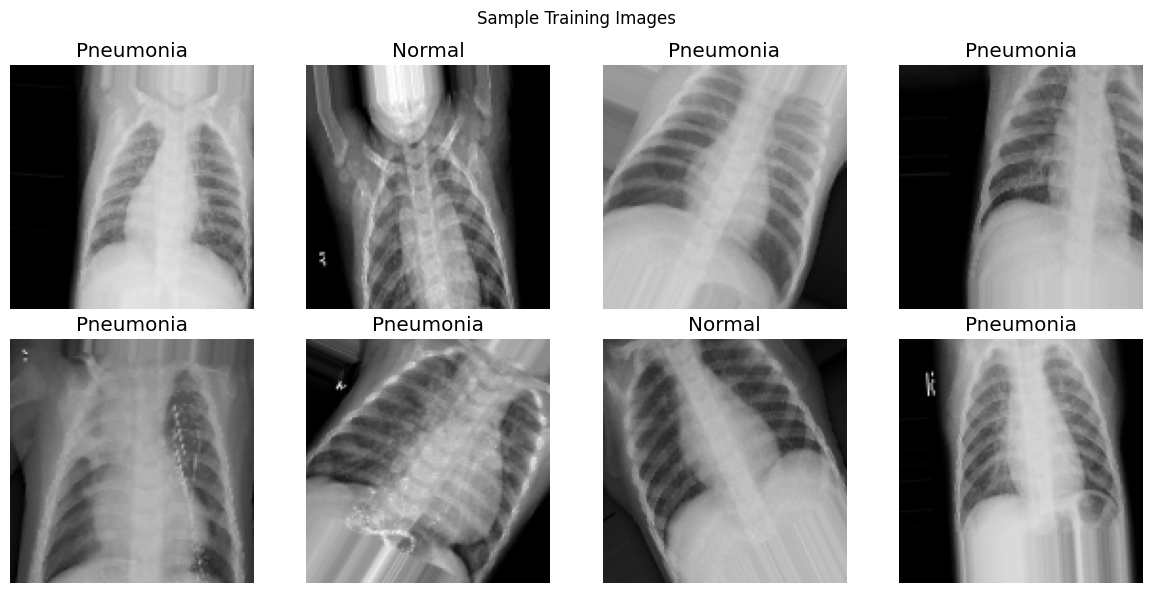

In [18]:
def visualize_samples(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.title("Pneumonia" if np.argmax(labels[i]) == 1 else "Normal")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_samples(train_generator, "Sample Training Images")


In [19]:
# Load VGG19 base model
base_model = VGG19(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,220,226 (92.39 MB)

 Trainable params: 4,195,842 (16.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
# Callbacks
checkpoint = ModelCheckpoint("vgg19_pneumonia_model.keras", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=0.00001)

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 383ms/step - accuracy: 0.7201 - loss: 0.5956 - val_accuracy: 0.8125 - val_loss: 0.5205 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.8262 - loss: 0.3769 - val_accuracy: 0.8125 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 374ms/step - accuracy: 0.8469 - loss: 0.3442 - val_accuracy: 0.8125 - val_loss: 0.4852 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 388ms/step - accuracy: 0.8566 - loss: 0.3211 - val_accuracy: 0.8125 - val_loss: 0.4876 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 381ms/step - accuracy: 0.8650 - loss: 0.2974 - val_accuracy: 0.8125 - val_loss: 0.4573 - learning_rate: 5.0000e-05
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.8797 - loss: 0.2832 - val_accuracy: 0.8125 - val_loss: 0.4502 - learning_rate: 5.0000e-05
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 386ms/step - 

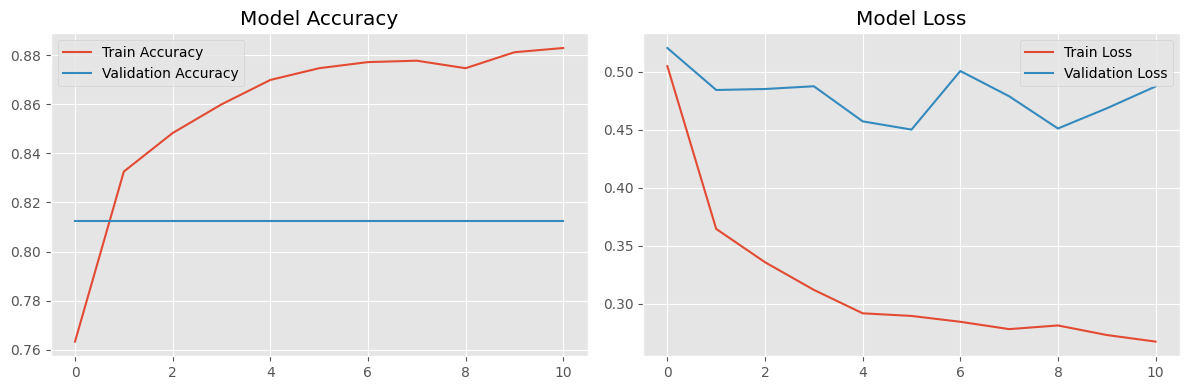

In [21]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8125 - loss: 0.3999
Test Accuracy: 81.73%
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step


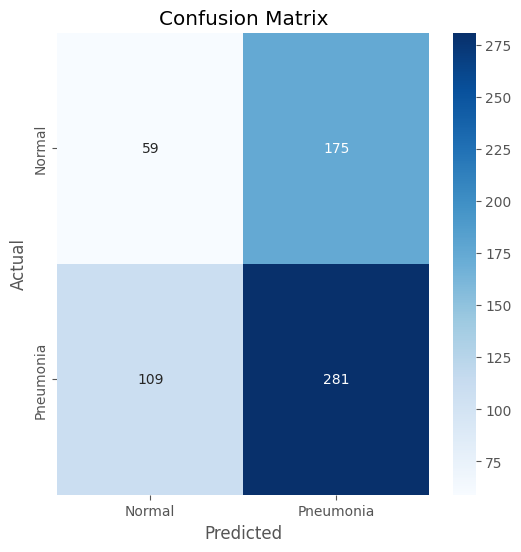

              precision    recall  f1-score   support

      Normal       0.35      0.25      0.29       234
   Pneumonia       0.62      0.72      0.66       390

    accuracy                           0.54       624
   macro avg       0.48      0.49      0.48       624
weighted avg       0.52      0.54      0.53       624



In [22]:
# Evaluate on test data
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm, classes=["Normal", "Pneumonia"])
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


In [23]:
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def plot_grad_cam(img_path, model, layer_name='block5_conv4'):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = grad_cam(model, img_array, layer_name)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

    plt.imshow(overlay)
    plt.title("Grad-CAM Visualization")
    plt.axis('off')
    plt.show()

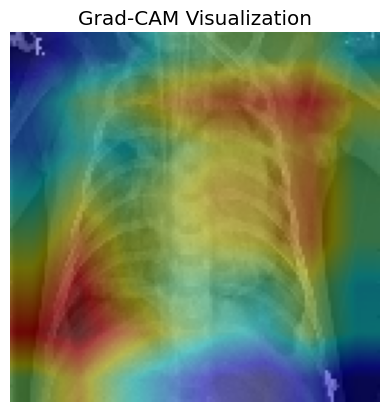

In [28]:
# Test Grad-CAM
example_img = r"./chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg"
plot_grad_cam(example_img, model)

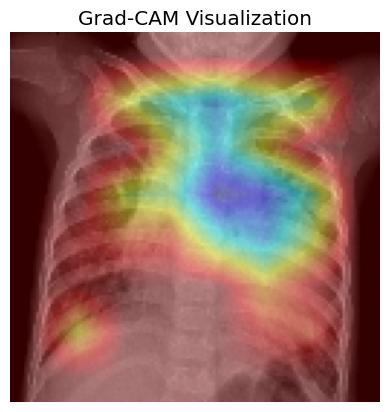

In [30]:
# Test Grad-CAM
example_img = r"./chest_xray/chest_xray/test/PNEUMONIA/person108_bacteria_511.jpeg"
plot_grad_cam(example_img, model)

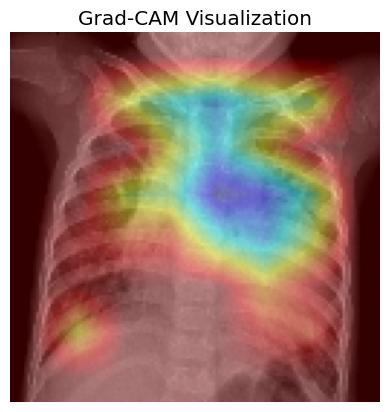

In [31]:
# Test Grad-CAM
example_img = r"./chest_xray/chest_xray/test/PNEUMONIA/person108_bacteria_511.jpeg"
plot_grad_cam(example_img, model)

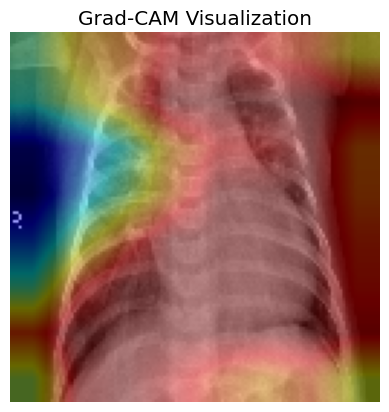

In [32]:
# Test Grad-CAM
example_img = r"./chest_xray/chest_xray/test/PNEUMONIA/person120_bacteria_573.jpeg"
plot_grad_cam(example_img, model)